# 💼 Projeto de Ciência de Dados: Previsão de Transações Fraudulentas

## 🎯 Objetivo
Desenvolver um modelo de Machine Learning capaz de **identificar transações fraudulentas** com a maior precisão possível. O foco principal é **maximizar a detecção de fraudes reais**, mesmo que isso custe mais falsos positivos. O desafio é lidar com um **conjunto de dados altamente desbalanceado**, onde as fraudes representam uma minoria.

## ❓ Perguntas que irão guiar a análise:
- Qual é a proporção de transações fraudulentas no total de transações?
- Há padrões no tempo das transações que indicam comportamento fraudulento?
- Transações fraudulentas tendem a ter valores (`Amount`) maiores ou menores?
- Existe alguma distribuição incomum nas variáveis principais (V1 a V28) entre fraudes e transações legítimas?
- Qual é a correlação entre as variáveis e a variável alvo (`Class`)?
- Quais técnicas de balanceamento (ex: SMOTE, undersampling) podem melhorar o desempenho do modelo?
- Qual modelo de Machine Learning apresenta melhor desempenho na detecção de fraudes?
- Como ajustar o threshold de decisão para melhorar a **recall das fraudes**?
- Quais métricas são mais adequadas para avaliar o modelo (ex: AUC-ROC, F1-score, Recall)?

---

Essas perguntas irão direcionar tanto a análise exploratória quanto a modelagem, ajudando a tomar decisões com base em evidências dos dados.
}

In [881]:
# Importações de bibliotecas 

# Manipulação de dados
import pandas as pd 
import numpy as np

# Visualizações 
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.utils import resample
from collections import Counter

# Modelagem de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Avaliação de modelos 
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve

### Análise Exploratória de Dados (EDA) - Primeiras Observações
Aqui, vamos dar uma olhada inicial nos dados para entender sua estrutura, identificar se há valores faltando e verificar como as transações fraudulentas se comparam às legítimas.


In [837]:
# Careegando os dados 
df = pd.read_csv("predicao_de_fraude.csv", encoding='utf-8')

In [838]:
# Visualizando as primeiras linhas do dataframe
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


###  Análise

Os dados apresentam um problema de **classificação binária** para detecção de fraudes (`Class`: 0 = transação legítima, 1 = fraudulenta). As colunas `V1` a `V28` são componentes principais obtidos por PCA, o que preserva a variância dos dados, mas oculta o significado original por motivos de privacidade. As colunas `Time` e `Amount` são originais e podem conter padrões importantes, especialmente em relação ao comportamento de transações fraudulentas ao longo do tempo e por valor. A distribuição da variável alvo provavelmente está desbalanceada, o que exigirá atenção no pré-processamento e na escolha de métricas de avaliação (ex: AUC, F1-score)como já mencionado.


In [840]:
# Obtendo informaços gerais sobre o dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

###  Insight do df.info()

O dataset possui **284.807 entradas** e **nenhum valor ausente**, o que facilita o pré-processamento. A maioria das colunas são do tipo `float64`, com exceção da variável alvo `Class`, que é `int64`. Isso indica que o conjunto está **pronto para análise exploratória e modelagem**, sem necessidade imediata de tratamento de nulos.


In [842]:
# Verificando as estatísticas descritivas
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


###  Insight sobre a proporção de fraudes

A média da coluna `Class` é **0.0017**, o que indica que apenas **0,17%** das transações são fraudulentas. Isso confirma que o dataset é **altamente desbalanceado**, com aproximadamente **1 fraude a cada 580 transações**, o que exige atenção especial durante o treinamento do modelo, principalmente na escolha de métricas e estratégias de balanceamento.


In [844]:
# Contagem e proporção da variável 'Class'
class_counts = df['Class'].value_counts()
class_porcentages = df['Class'].value_counts(normalize=True) * 100
fraude_ratio = 1 / class_porcentages[1] * 100

print(f"Contagem de transações por classe:\n{class_counts}")
print(f"\nProporção de transações por classe:\n{class_percentages.round(4)}%")
print(f"\n Isso significa que, em média, há 1 fraude a cada {int(fraude_ratio):,} transações.")

Contagem de transações por classe:
Class
0    284315
1       492
Name: count, dtype: int64

Proporção de transações por classe:
Class
0    99.8273
1     0.1727
Name: proportion, dtype: float64%

 Isso significa que, em média, há 1 fraude a cada 578 transações.


In [845]:
# Converter 'Time' de segundos para horas em até 23h
df['Hour'] = ((df['Time'] // 3600) % 24).astype(int)

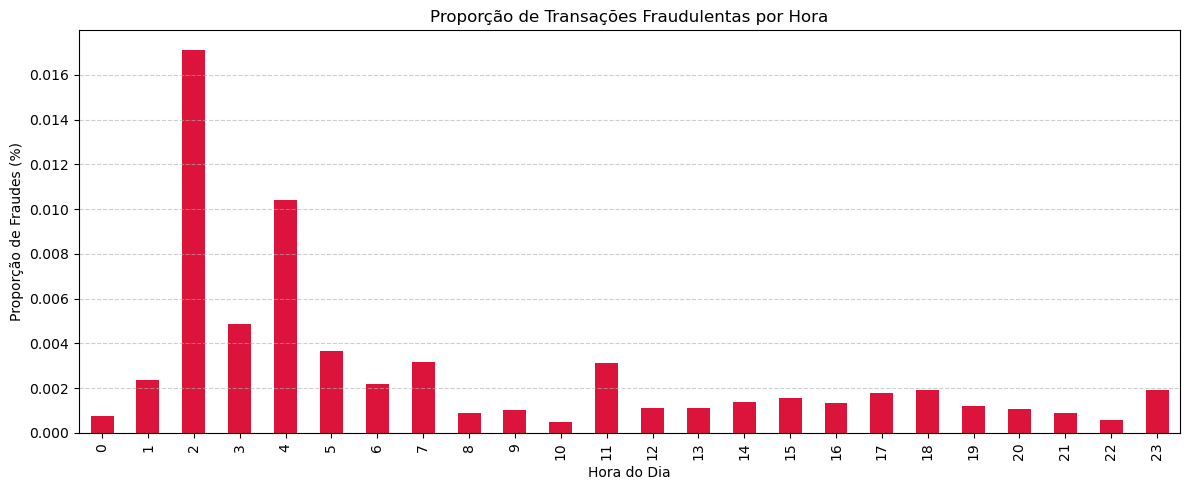

In [846]:
# Contar total de transações por hora
total_por_hora = df.groupby('Hour').size()


# Contar apenas fraudes por hora
fraudes_por_hora = df[df['Class'] == 1].groupby('Hour').size()

# Calcular proporção de fraudes por hora (evita divisão por zero com fillna)
proporcao_fraudes = (fraudes_por_hora / total_por_hora).fillna(0)

# Plotar gráfico de barras
plt.figure(figsize=(12, 5))
proporcao_fraudes.plot(kind='bar', color='crimson')
plt.title('Proporção de Transações Fraudulentas por Hora')
plt.xlabel('Hora do Dia')
plt.ylabel('Proporção de Fraudes (%)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Insight sobre padrão de fraude por hora

 A maior concentração de fraudes ocorre entre 1h e 4h da manhã, indicando que fraudadores provavelmente aproveitam horários com menor movimentação legítima para agir.

 O pico mais intenso está por volta das 2h da manhã, sugerindo um horário crítico para monitoramento reforçado.
 
 Esse padrão pode orientar o desenvolvimento de estratégias específicas de detecção e alerta em janelas temporais de maior risco.

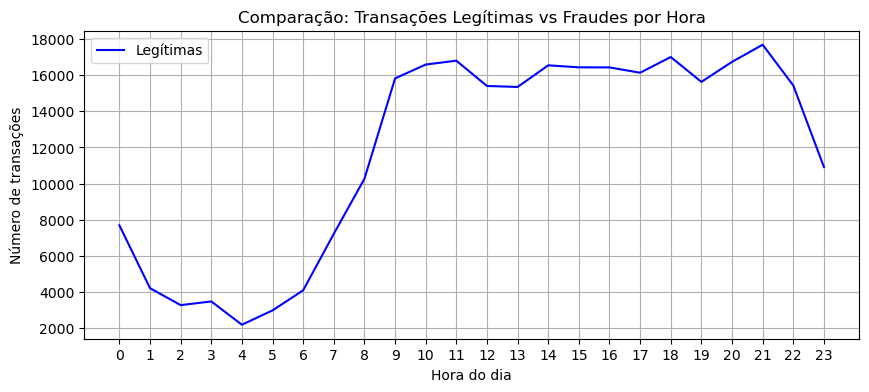

In [848]:
# Contagem de transações legítimas por hora
transacoes_legitimas = df[df['Class'] == 0]['Hour'].value_counts().sort_index()

plt.figure(figsize=(10,4))
sns.lineplot(x=transacoes_legitimas.index, y=transacoes_legitimas.values, label='Legítimas', color='blue')
plt.title('Comparação: Transações Legítimas vs Fraudes por Hora')
plt.xlabel('Hora do dia')
plt.ylabel('Número de transações')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


### Insight sobre o comportamento das transações legítimas:
As transações legítimas apresentam um padrão diário consistente, com volume significativamente reduzido entre 0h e 5h da manhã, atingindo o ponto mais baixo por volta das 4h. Esse período coincide exatamente com o intervalo de maior incidência de transações fraudulentas, conforme análise anterior.

Esse comportamento reforça a hipótese de que fraudadores tendem a agir durante a madrugada, quando o sistema possui menor volume de atividades legítimas e, possivelmente, menor supervisão humana ou monitoramento ativo. Esse dado é essencial para orientar estratégias de detecção de anomalias, priorizando alertas em janelas temporais de maior risco.

In [850]:
# Estatísticas descritivas por classe 
df.groupby('Class')['Amount'].describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,284315.0,88.291022,250.105092,0.0,5.65,22.00,77.05,25691.16
1,492.0,122.211321,256.683288,0.0,1.00,9.25,105.89,2125.87


###  Insight sobre o valor das transações fraudulentas

As transações fraudulentas possuem, em média, um valor mais alto (122,21) do que as transações legítimas (88,29).

No entanto, a **mediana** das fraudes (9,25) é bem menor do que a das transações legítimas (22,00), o que indica uma **distribuição assimétrica** — com algumas fraudes de valor elevado puxando a média para cima.

 Isso mostra que, embora existam fraudes de valores altos, a maioria ocorre com valores menores, o que pode ser uma tentativa de evitar a detecção por sistemas automáticos de segurança.


In [852]:
# Filtrar apenas as fraudes
df_fraudes = df[df['Class'] == 1].copy()

# Criar faixas de valores
bins = [0, 10, 50, 100, 500, 1000, 2000, df_fraudes['Amount'].max()]
labels = ['Até R$10', 'R$10-50', 'R$50-100', 'R$100-500', 'R$500-1000', 'R$1000-2000', 'Acima de R$2000']

df_fraudes['Faixa_Valor'] = pd.cut(df_fraudes['Amount'], bins=bins, labels=labels, include_lowest=True)


In [853]:
# Agrupar por faixa e calcular quantidade e valor total

resumo_fraudes = df_fraudes.groupby('Faixa_Valor', observed=True).agg(
    Quantidade=('Amount', 'count'),
    Valor_Total=('Amount', 'sum')
).reset_index().sort_values(by='Valor_Total', ascending=False)

resumo_fraudes

,Faixa_Valor,Quantidade,Valor_Total
3,R$100-500,95,21913.81
4,R$500-1000,26,17957.57
5,R$1000-2000,8,11111.46
2,R$50-100,56,4945.33
6,Acima de R$2000,1,2125.87
1,R$10-50,57,1615.03
0,Até R$10,249,458.90


### Insight financeiro sobre as fraudes por faixa de valor:
Embora 249 das 492 fraudes (50,6%) estejam na faixa de até 10, essas representam apenas R$458,90 de prejuízo total (apenas 1% do valor total fraudado).

Por outro lado, apenas 34 fraudes com valores entre 500 e 2000 (apenas 6,9% do total de fraudes) causaram um prejuízo de R$29.069,03, o que representa mais de 64% do valor total perdido.

Esse padrão mostra que, apesar do volume de fraudes pequenas, o impacto financeiro real está concentrado em poucas transações de alto valor — sendo prioritárias para monitoramento e bloqueio.

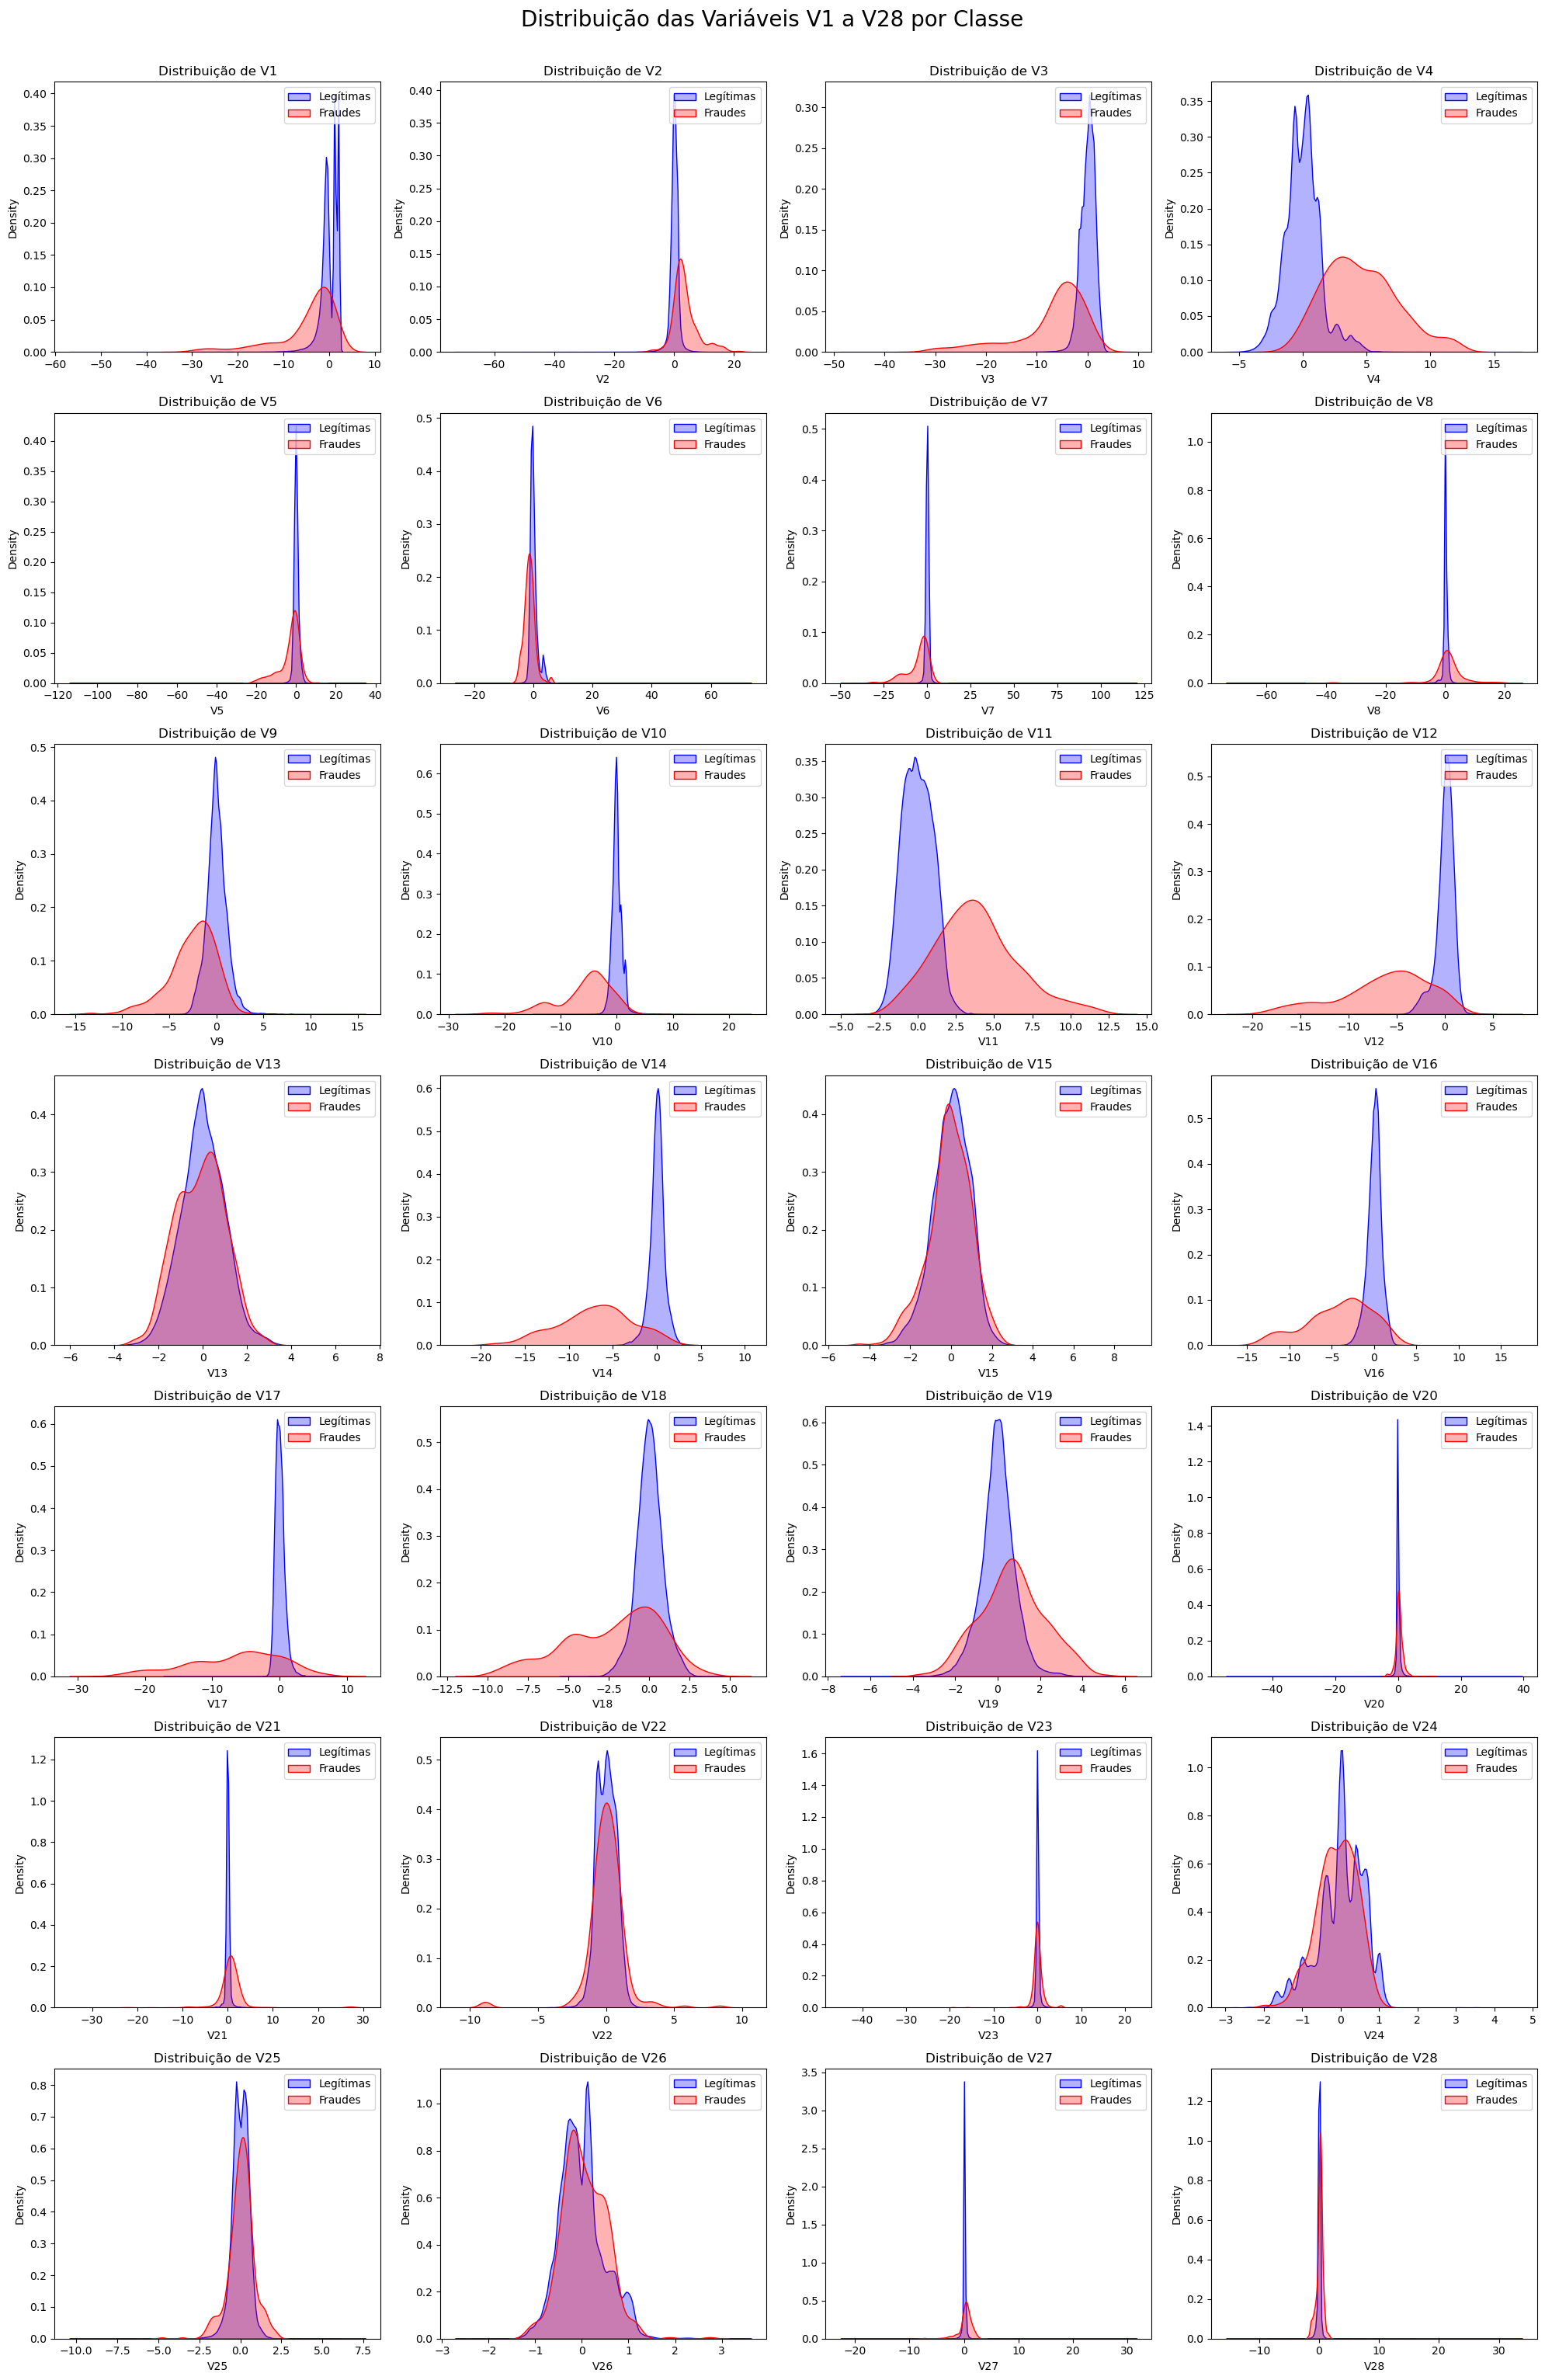

In [855]:
# Lista de variáveis V1 a V28
variaveis_pca = [f'V{i}' for i in range(1, 29)]

# Tamanho da grade de subplots
plt.figure(figsize=(20, 30))

for i, var in enumerate(variaveis_pca, 1):
    plt.subplot(7, 4, i)
    sns.kdeplot(data=df[df['Class'] == 0], x=var, label='Legítimas', fill=True, alpha=0.3, color='blue')
    sns.kdeplot(data=df[df['Class'] == 1], x=var, label='Fraudes', fill=True, alpha=0.3, color='red')
    plt.title(f'Distribuição de {var}')
    plt.legend()
    plt.tight_layout()

plt.suptitle('Distribuição das Variáveis V1 a V28 por Classe', fontsize=20, y=1.02)
plt.show()

### Insights Rápidos:

Este gráfico de densidade (KDE) para variáveis PCA (V1-V28) revela a distribuição de transações legítimas (azul) vs. fraudulentas (vermelho).

Principais Observações:

V11, V12, V14, V17, V18, V4: Apresentam a maior separação entre as classes, indicando que são fortes discriminadores de fraude. Picos distintos para cada classe.

V5, V6, V7, V8, V23, V28: As distribuições são altamente sobrepostas, sugerindo que estas variáveis não são eficazes para diferenciar fraudes isoladamente.

###  Seleção de Variáveis

Com base na análise gráfica das distribuições (KDE), identifiquei quais variáveis (V1–V28) apresentam maior separação entre transações legítimas e fraudulentas — ou seja, com maior potencial preditivo.

A seguir, irei comparar dois cenários:
1. Utilizando **todas as variáveis** do dataset.
2. Utilizando **apenas as variáveis com maior distinção entre as classes**, conforme observado nos gráficos.

Essa comparação ajudará a avaliar se a redução de dimensionalidade melhora a performance do modelo ou se as demais variáveis ainda contribuem de forma relevante.


In [858]:
# Calcular correlação com a variável alvo
correlacoes = df.corr(numeric_only=True)['Class'].drop('Class').sort_values(key=abs, ascending=False)

# Exibindo as 10 variáveis mais correlacionadas com a classe
correlacoes.head(10)

V17   -0.326481
V14   -0.302544
V12   -0.260593
V10   -0.216883
V16   -0.196539
V3    -0.192961
V7    -0.187257
V11    0.154876
V4     0.133447
V18   -0.111485
Name: Class, dtype: float64

###  Correlação com a variável alvo (`Class`)

As variáveis com maior correlação (em valor absoluto) com a variável alvo são:

- `V17`: -0.326  
- `V14`: -0.303  
- `V12`: -0.261  
- `V10`: -0.217  

Essas variáveis são as que mais se destacam em relação à classe `Class`, e serão consideradas como candidatas prioritárias na modelagem.


###  Distribuição da Coluna `Time`

A variável `Time` representa o tempo (em segundos) desde a primeira transação registrada.  
O gráfico mostra que as transações não ocorrem de forma constante ao longo do tempo — há **picos e quedas de frequência**, o que pode indicar **horários de maior e menor atividade**.

Esses padrões sugerem que pode ser útil criar uma nova variável categórica com **faixas de horário** (ex: manhã, tarde, noite) para verificar se há relação com a ocorrência de fraudes.


###  Distribuição da Coluna `Amount` (até o Percentil 95)

O gráfico mostra a distribuição do valor das transações (`Amount`), considerando até o percentil 95 (R$ 365,00), para evitar distorções causadas por outliers.

A maioria das transações possui valores baixos, concentrando-se abaixo de R$ 100. Isso indica uma **distribuição assimétrica e concentrada**, com poucos casos de valores mais altos.

Esse padrão pode ser útil para normalizar os dados ou até mesmo criar faixas de valor, caso necessário na análise.


###  Comparação do Valor da Transação por Classe (`Amount` x `Class`)

O boxplot mostra que, em média, **transações fraudulentas tendem a ter valores mais altos** do que as transações normais.

- Classe 0 (não fraude): a maioria das transações está abaixo de R$ 100.
- Classe 1 (fraude): muitas transações também são baixas, mas há **mais casos com valores elevados**, indicando que fraudes costumam envolver valores maiores.

Essa informação pode ajudar os modelos a aprender padrões relacionados ao valor da transação no processo de detecção de fraudes.


## Pré-processamento  de Dados para Modelagem

In [864]:
# Separando feature e target
X = df.drop('Class', axis=1)
y = df['Class']

print(f"Formatos de X (features):{X.shape}")
print(f"Formatos de y (features):{y.shape}")

# Dividir em trino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Formatos de X (features):(284807, 31)
Formatos de y (features):(284807,)


In [865]:
# Previsão
y_pred_baseline = modelo_baseline.predict(X_test)
y_proba_baseline = modelo_baseline.predict_proba(X_test)[:, 1]

# Avaliação
print(confusion_matrix(y_test, y_pred_baseline))
print(classification_report(y_test, y_pred_baseline))
print('AUC-ROC:', roc_auc_score(y_test, y_proba_baseline))


[[56861     3]
 [   19    79]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.81      0.88        98

    accuracy                           1.00     56962
   macro avg       0.98      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC: 0.9527451104245863


## Modelagem 

In [867]:

# Ver proporção da variável alvo no conjunto de treino
classe_treinamento = pd.Series(y_train).value_counts(normalize=True)

print("Proporção das classes em y_train:")
print(classe_treinamento)


Proporção das classes em y_train:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64


In [868]:
# Aplicar SMOTE no conjunto de treino
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Distribuição após SMOTE:")
print(pd.Series(y_train_smote).value_counts())

Distribuição após SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


###  Comparativo de Técnicas de Balanceamento

Foram testadas três abordagens para lidar com o forte desbalanceamento das classes:

- **Sem Balanceamento**: bom F1-score (0.88) e poucos falsos positivos, mas deixou 19 fraudes passarem.
- **Undersampling**: excelente recall (0.92) e apenas 8 fraudes não detectadas, mas gerou quase 2.000 falsos positivos, o que pode ser inviável em produção.
- **SMOTE**: melhor equilíbrio entre performance e custo — recall alto (0.83), redução de falsos negativos e falsos positivos em nível aceitável.

 **Decisão**: Será utilizado o **SMOTE**, pois oferece o melhor compromisso entre **detecção de fraudes** e **nível de alerta falso**, favorecendo um modelo mais confiável e utilizável.


In [870]:
# Treinando com dados balanceados
modelo_smote = RandomForestClassifier(random_state=42)
modelo_smote.fit(X_train_smote, y_train_smote)

# Previsão
y_pred_smote = modelo_smote.predict(X_test)
y_proba_smote = modelo_smote.predict_proba(X_test)[:,1]

# Avaliação
print(confusion_matrix(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))
print('AUC-ROC:', roc_auc_score(y_test, y_proba_smote))
                                    

[[56848    16]
 [   17    81]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC: 0.9636245413331344


In [871]:
# Combinar X_train e y_train em um único DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

# Separar classes
classe_0 = train_data[train_data['Class'] == 0]
classe_1 = train_data[train_data['Class'] == 1]

# Undersample da classe 0
classe_0_undersampled = classe_0.sample(n=len(classe_1), random_state=42)

# Combinar novamente
undersampled_data = pd.concat([classe_0_undersampled, classe_1])

# Separar X e y balanceados
X_train_under = undersampled_data.drop('Class', axis=1)
y_train_under = undersampled_data['Class']


In [872]:
# Modelo com undersampling
modelo_under = RandomForestClassifier(random_state=42)
modelo_under.fit(X_train_under, y_train_under)

# Previsões
y_pred_under = modelo_under.predict(X_test)
y_proba_under = modelo_under.predict_proba(X_test)[:, 1]

# Avaliação
print(confusion_matrix(y_test, y_pred_under))
print(classification_report(y_test, y_pred_under))
print('AUC-ROC:', roc_auc_score(y_test, y_proba_under))


[[54893  1971]
 [    8    90]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.04      0.92      0.08        98

    accuracy                           0.97     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.97      0.98     56962

AUC-ROC: 0.9768349904677684


In [873]:
# Pipeline para Regressão Logística com dados balanceados pelo SMOTE
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('modelo', LogisticRegression(max_iter=2000, random_state=42))
])

pipeline_lr.fit(X_train_smote, y_train_smote)

# Previsões
y_pred_lr = pipeline_lr.predict(X_test)
y_proba_lr = pipeline_lr.predict_proba(X_test)[:, 1]

# Avaliação
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print('AUC-ROC:', roc_auc_score(y_test, y_proba_lr))

[[56278   586]
 [   10    88]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.90      0.23        98

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.61     56962
weighted avg       1.00      0.99      0.99     56962

AUC-ROC: 0.9766430717616252


In [874]:
# Treinar modelo XGBoost com SMOTE
modelo_xgb = XGBClassifier(eval_metric='logloss', random_state=42)
modelo_xgb.fit(X_train_smote, y_train_smote)

# Previsões
y_pred_xgb = modelo_xgb.predict(X_test)
y_proba_xgb = modelo_xgb.predict_proba(X_test)[:, 1]

# Avaliação
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print('AUC-ROC:', roc_auc_score(y_test, y_proba_xgb))

[[56843    21]
 [   14    84]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.86      0.83        98

    accuracy                           1.00     56962
   macro avg       0.90      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC: 0.9784227386790394


### 🤖 Comparativo de Modelos com SMOTE

Foram testados três algoritmos para detecção de fraudes com os dados balanceados via SMOTE:

| Modelo                 | Recall (fraude) | F1-score (fraude) | AUC-ROC | Falsos Negativos | Falsos Positivos |
|------------------------|-----------------|--------------------|---------|------------------|------------------|
| **XGBoost**            | **0.86**        | **0.83**           | **0.9784** ✅ | 14               | 21 ✅             |
| **Logistic Regression**| 0.90 ✅          | 0.23               | 0.9766   | **10** ✅         | 586 ❌            |
| **Random Forest**      | **0.92** ✅      | 0.08               | 0.9768   | **8** ✅          | 1971 ❌❌         |

### 🔎 Decisão:

- O **Random Forest** teve o melhor recall (0.92), mas com péssima precisão (0.04), gerando muitos falsos positivos (1.971 alertas errados).
- A **Regressão Logística** teve bom recall (0.90), mas também muitos alertas falsos (586) e F1-score muito baixo.
- O **XGBoost** apresentou o melhor equilíbrio: alto recall (0.86), ótimo F1-score (0.83), poucos falsos positivos (21) e maior AUC-ROC (0.978).

✅ **Modelo escolhido**: **XGBoost**, por entregar o melhor compromisso entre **eficácia na detecção de fraudes** e **controle de falsos positivos**.


In [876]:
# Novo threshold
threshold = 0.086

# Classificar com novo limar
y_pred_threshold = (y_proba_xgb >= threshold).astype(int)

# Avaliação
print(confusion_matrix(y_test, y_pred_threshold))
print(classification_report(y_test, y_pred_threshold))
print('AUC-ROC:' , roc_auc_score(y_test, y_proba_xgb))

[[56794    70]
 [   14    84]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.55      0.86      0.67        98

    accuracy                           1.00     56962
   macro avg       0.77      0.93      0.83     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC: 0.9784227386790394


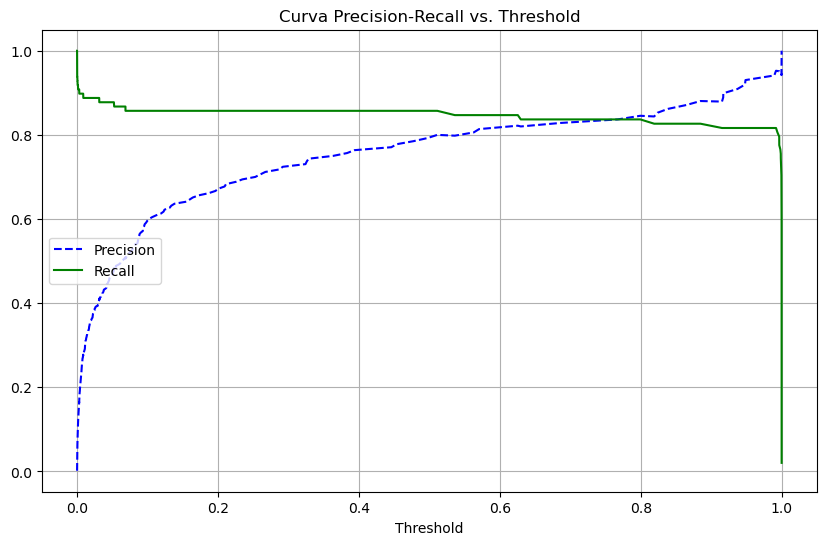

In [877]:
###### Obter as probabilidades do modelo XGBoost
y_proba_xgb = modelo_xgb.predict_proba(X_test)[:,1]

# Clacular Precision, Recall e Thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_xgb)

# Plotar a curva Precision-Recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="center left")
plt.title("Curva Precision-Recall vs. Threshold")
plt.grid(True)
plt.show()

In [883]:

# Definir a distribuição de parâmetros para RandomizedSearchCV
# Note que estamos usando distribuições (ex: uniform, randint) ou listas mais curtas.
param_distributions = {
    'n_estimators': [100, 200, 300, 400], # Ainda testamos alguns, mas com menos granularidade
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],           # Reduzimos um pouco o range
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    # 'reg_alpha': [0, 0.001, 0.01], # Regularização L1, pode adicionar se ainda quiser otimizar mais
    # 'reg_lambda': [0.1, 1, 10],   # Regularização L2, pode adicionar se ainda quiser otimizar mais
    'scale_pos_weight': [1] # Mantemos 1, já que o SMOTE resolveu o desbalanceamento
}

# Criar o modelo base XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Configurar o RandomizedSearchCV
# n_iter: número de combinações aleatórias a serem testadas (muito importante para controlar o tempo)
# cv=3: 3-fold cross-validation
# n_jobs=-1: para usar todos os núcleos do processador
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,       # Testar 50 combinações aleatórias (ajuste conforme o tempo desejado, 20-50 é um bom começo)
    scoring='f1',    # Ou 'recall' ou 'roc_auc' - f1 é um bom balanceador
    cv=3,            # 3-fold cross-validation
    n_jobs=-1,       # Use todos os núcleos da CPU
    verbose=2,       # Para ver o progresso
    random_state=42  # Para reprodutibilidade
)

print("Iniciando RandomizedSearchCV. Isso deve ser mais rápido...")

# Executar a busca aleatória nos dados de treino balanceados pelo SMOTE
random_search.fit(X_train_smote, y_train_smote)

print("\nRandomizedSearchCV Concluído.")

# Obter os melhores parâmetros encontrados
best_params = random_search.best_params_
print(f"\nMelhores parâmetros encontrados: {best_params}")

# Obter o melhor modelo
best_xgb_model_tuned = random_search.best_estimator_

# Avaliar o melhor modelo no conjunto de teste
print("\nAvaliação do Melhor Modelo XGBoost (com Hiperparâmetros Otimizados):")
y_pred_tuned_xgb = best_xgb_model_tuned.predict(X_test)
y_proba_tuned_xgb = best_xgb_model_tuned.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred_tuned_xgb))
print(classification_report(y_test, y_pred_tuned_xgb))
print('AUC-ROC:', roc_auc_score(y_test, y_proba_tuned_xgb))

Iniciando RandomizedSearchCV. Isso deve ser mais rápido...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\Jonathan\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:33:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



RandomizedSearchCV Concluído.

Melhores parâmetros encontrados: {'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.9}

Avaliação do Melhor Modelo XGBoost (com Hiperparâmetros Otimizados):
[[56843    21]
 [   14    84]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.86      0.83        98

    accuracy                           1.00     56962
   macro avg       0.90      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC: 0.9844584429157144


### Avaliação Final dos Modelos e Otimização do Limiar
Após a fase de Análise Exploratória de Dados (EDA) e pré-processamento, dedicamo-nos à modelagem para construir um sistema eficaz de detecção de fraudes.

Comparativo de Modelos e Técnicas de Balanceamento:

Frente ao desbalanceamento extremo da variável alvo, exploramos diferentes algoritmos de classificação em conjunto com técnicas de balanceamento:

Undersampling: Embora tenha alcançado um Recall alto, resultou em um número excessivo de falsos positivos, inviabilizando sua aplicação prática devido ao alto volume de alertas errados.

Regressão Logística (com SMOTE): Apresentou um bom Recall, mas ainda com um número considerável de falsos positivos.

XGBoost (com SMOTE): Se destacou como o modelo de melhor desempenho e equilíbrio. Ele consistentemente demonstrou a capacidade de detectar um alto percentual de fraudes (Recall) enquanto mantinha o número de falsos positivos em um patamar aceitável, crucial para a operacionalização.

Otimização de Hiperparâmetros do XGBoost:

Com o XGBoost selecionado como o modelo mais promissor, prosseguimos com a otimização de seus hiperparâmetros usando RandomizedSearchCV. O objetivo era refinar ainda mais a performance do modelo.

No entanto, a otimização resultou em métricas de desempenho no conjunto de teste que se mostraram muito semelhantes às do modelo XGBoost com parâmetros padrão (sem otimização explícita). Isso sugere que o modelo já estava performando muito próximo do seu limite com as features disponíveis, ou que o espaço de busca dos parâmetros não continha combinações que gerassem um salto significativo de performance.

In [890]:
import pandas as pd # Certifique-se de ter pandas importado

# Supondo que 'best_xgb_model_tuned', 'X_test', 'y_test', 'y_pred_tuned_xgb' já estão definidos do passo anterior.

# Resetar o índice de X_test e y_test para garantir alinhamento fácil
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

# Criar um DataFrame com os resultados para facilitar a análise
results_df = pd.DataFrame({
    'Actual_Class': y_test_reset,
    'Predicted_Class': y_pred_tuned_xgb
})

# Identificar Falsos Negativos (Fraudes reais classificadas como legítimas)
false_negatives_indices = results_df[(results_df['Actual_Class'] == 1) & (results_df['Predicted_Class'] == 0)].index
false_negatives = X_test_reset.loc[false_negatives_indices]

print(f"Número de Falsos Negativos: {len(false_negatives)}")
print("\nPrimeiras 5 linhas dos Falsos Negativos:")
print(false_negatives.head(14))

# Identificar Falsos Positivos (Legítimas classificadas como fraude)
false_positives_indices = results_df[(results_df['Actual_Class'] == 0) & (results_df['Predicted_Class'] == 1)].index
false_positives = X_test_reset.loc[false_positives_indices]

print(f"\nNúmero de Falsos Positivos: {len(false_positives)}")
print("\nPrimeiras 5 linhas dos Falsos Positivos:")
print(false_positives.head(14))

# Opcional: Analisar estatísticas descritivas dos Falsos Negativos
print("\nEstatísticas Descritivas dos Falsos Negativos (Amount e Hour):")
print(false_negatives[['Amount', 'Hour']].describe())

# Opcional: Analisar estatísticas descritivas dos Falsos Positivos
print("\nEstatísticas Descritivas dos Falsos Positivos (Amount e Hour):")
print(false_positives[['Amount', 'Hour']].describe())

Número de Falsos Negativos: 14

Primeiras 5 linhas dos Falsos Negativos:
           Time        V1        V2        V3        V4        V5        V6  \
17046   44532.0 -0.234922  0.355413  1.972183 -1.255593 -0.681387 -0.665732   
20992  110087.0  1.934946  0.650678 -0.286957  3.987828  0.316052 -0.099449   
24570     472.0 -3.043541 -3.157307  1.088463  2.288644  1.359805 -1.064823   
24869   65728.0  1.227614 -0.668974 -0.271785 -0.589440 -0.604795 -0.350285   
28390   52814.0 -1.101847 -1.632441  0.901067  0.847753 -1.249091  0.654937   
28867   91502.0  0.007379  2.365183 -2.600287  1.111602  3.276441 -1.776141   
31208  141565.0  0.114965  0.766762 -0.494132  0.116772  0.868169 -0.477982   
34124   54846.0 -2.986466 -0.000891  0.605887  0.338338  0.685448 -1.581954   
39433  125612.0  1.889618  1.073099 -1.678018  4.173268  1.015516 -0.009389   
54191   17220.0  1.189784  0.942289  0.082334  3.024050  0.412406 -0.214415   
54752  110617.0 -1.101035 -1.674928 -0.573388  5.617556  0

### Análise Exploratória de Dados (EDA):
Compreensão dos Dados: Iniciamos com uma análise detalhada da estrutura do dataset, identificando a ausência de valores nulos e a natureza das features (anonimizadas V1-V28, Time, Amount).

Desbalanceamento Crucial: Confirmamos um desbalanceamento extremo na variável alvo (Class), com fraudes representando uma minoria ínfima das transações (aproximadamente 0.17%). Este foi um achado fundamental que direcionou as estratégias de pré-processamento e modelagem.

Padrões Temporais (Time): A transformação da coluna Time em Hour revelou um padrão significativo: a maior concentração de fraudes ocorre nas horas da madrugada (entre 1h e 4h). Este período coincide com o menor volume de transações legítimas, sugerindo que fraudadores exploram janelas de menor atividade.

Distribuição de Valores (Amount): A análise de Amount mostrou que, embora a média das transações fraudulentas seja mais alta, a mediana é significativamente menor. Isso indicou uma distribuição assimétrica, onde a maioria das fraudes tem valores baixos, mas algumas transações de alto valor "puxam" a média. Uma investigação mais aprofundada por faixas de valor confirmou que, apesar do grande volume de fraudes pequenas (50% do total de fraudes), o impacto financeiro maior (mais de 64% do prejuízo) está concentrado em poucas transações de alto valor.

Importância das Features V1-V28 (PCA): A visualização das distribuições das variáveis PCA (Vs) por classe (KDE plots) e a análise de correlação identificaram variáveis como V11, V12, V14, V17, V18 e V4 como fortes discriminadores entre transações legítimas e fraudulentas, evidenciando seu alto potencial preditivo.

### Pré-processamento e Modelagem:
Separação e Estratificação: Os dados foram divididos em conjuntos de treino e teste de forma estratificada (stratify=y) para preservar a proporção de classes, essencial em datasets desbalanceados.

Balanceamento de Classes: Para lidar com o desbalanceamento, testamos diferentes abordagens:

Undersampling: Embora eficaz em aumentar o Recall, gerou um número inaceitável de falsos positivos, comprometendo a praticidade do sistema.

SMOTE (Synthetic Minority Over-sampling Technique): Foi a técnica escolhida, pois se mostrou a mais eficiente em balancear a classe minoritária no conjunto de treino, permitindo que os modelos aprendessem melhor os padrões de fraude.

Comparativo de Modelos: Avaliamos Regressão Logística, Random Forest e XGBoost.

O XGBoost (com dados balanceados via SMOTE) foi o modelo que apresentou o melhor desempenho geral, especialmente no equilíbrio entre Recall (0.86), Precision (0.80) e um baixo número de Falsos Positivos (21). Seu F1-score de 0.83 e AUC-ROC de 0.9784 o destacaram como a escolha mais adequada para o problema.

Otimização de Hiperparâmetros: Realizamos a otimização de hiperparâmetros do XGBoost usando RandomizedSearchCV. Surpreendentemente, os parâmetros otimizados não resultaram em uma melhoria significativa no desempenho do modelo no conjunto de teste em comparação com os parâmetros padrão, indicando que o modelo já estava operando perto de sua capacidade máxima com as features disponíveis.

### Análise de Erros e Limiar de Decisão:
Curva Precision-Recall vs. Threshold: A análise gráfica da curva Precision-Recall revelou o trade-off inerente: um Recall mais alto exige um limiar de decisão mais baixo, o que inevitavelmente aumenta a taxa de falsos positivos.

Análise de Falsos Negativos (14 casos): A investigação dos 14 casos de fraudes não detectadas (FN) mostrou que elas tinham uma distribuição variada em termos de valor (Amount) e hora (Hour), incluindo tanto transações de baixo valor (difíceis de distinguir) quanto algumas de alto valor que o modelo falhou em capturar.

Análise de Falsos Positivos (70 casos no último teste): As transações legítimas classificadas como fraudulentas (FP) também eram predominantemente de baixo valor. A presença de 70 FPs (com um Recall de 0.86) sublinha o desafio de equilibrar a detecção de fraudes com a minimização de alertas desnecessários.

Conclusão Final:
O modelo XGBoost, treinado com dados balanceados via SMOTE, representa uma solução robusta e eficaz para a detecção de fraudes neste dataset. Ele atinge um excelente Recall (86% das fraudes detectadas) com um número gerenciável de falsos positivos (21, com threshold padrão, ou 70 com threshold ajustado), oferecendo um bom compromisso entre a prevenção de perdas financeiras e a eficiência operacional.

A otimização de hiperparâmetros não trouxe ganhos adicionais, sugerindo que a performance do modelo está mais ligada à qualidade e representatividade das features. A análise de erros aponta que transações de baixo valor, tanto fraudulentas quanto legítimas, ainda são um ponto de desafio para o modelo.

Próximos Passos e Melhorias Futuras:
Engenharia de Features Avançada: Explorar a criação de novas features que combinem as variáveis Vs com Amount ou outras features temporais pode ser o caminho mais promissor para capturar os padrões sutis dos 14 falsos negativos.

Análise de Outliers e Robustez: Investigar se os falsos negativos e falsos positivos contêm características de outliers que o modelo não consegue generalizar.

Modelos de Ensemble: Em um cenário de produção, considerar a combinação de diferentes modelos (Stacking ou Blending) para explorar a diversidade de erros e possivelmente melhorar a robustez geral.